# Clustering Stefano Boccaletti's collaboration network

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import xgi
from scipy.cluster import hierarchy
from collections import defaultdict
from itertools import combinations, product

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

from hyperfunctions import *
from modularity_functions import *

##  Constructing the Hypergraph

We create the hypergraph with Stefano's coauthors and their respective coauthors.

In [2]:
df = pd.read_csv('Datasets/boccaletti_and_cocoauthors.csv', sep = ';')

hyperedge_dict = {}
for paper, ID in enumerate(df['Author(s) ID']):
    hyperedge_dict[paper] = ID.split(';')[:-1]

H = xgi.Hypergraph(hyperedge_dict)
print(len(H.edges), len(H.nodes))

15237 20227


We create the hypergraph with only Stefano's coauthors. We can apply some restrictions to the number of papers with him to be considered a coauthor.

In [3]:
restriction_papers = 5

In [4]:
dg = pd.read_csv('Datasets/boccaletti_coauthors.csv', sep = ',')

hyperedge_dic = {}
for paper, ID in enumerate(dg['Author(s) ID']):
    hyperedge_dic[paper] = ID.split(';')[:-1]

E = xgi.Hypergraph(hyperedge_dic)

print(len(E.edges), len(E.nodes))

for node in list(E.nodes):
    if E.degree(node) < restriction_papers:
        E.remove_node(node)     

print(len(E.edges), len(E.nodes))

338 414
338 69


Keep from the first hypergraph (H) the nodes from the second hypergraph (E)

In [5]:
for node in list(H.nodes):
    if node in list(E.nodes):
        continue
    else:
        H.remove_node(node)
        
# Also remove Stefano Boccaletti
H.remove_node('7006291912')

# Also remove outlier (Soregaroli, not a coauthor)
H.remove_node('15133256400')

H.remove_edges_from(H.edges.singletons())

In [6]:
print(len(H.nodes), len(H.edges))

67 1685


In [7]:
nodes_list = list(H.nodes)

In [8]:
Authors_list = []
IDs_list = []
for author, ID in zip(dg['Authors'],dg['Author(s) ID']):
    Authors_list.append(author.split(', '))
    IDs_list.append(ID.split(';')[:-1])

authors_dict = {}
IDs_dict={}
for cont, authors in enumerate(Authors_list):
    for cont_2, author in enumerate(authors):
        IDs_dict[IDs_list[cont][cont_2]] = author
        authors_dict[author] = IDs_list[cont][cont_2]
        

## Communities

In [9]:
derivative = derivative_list(H)

In [10]:
method = "average"

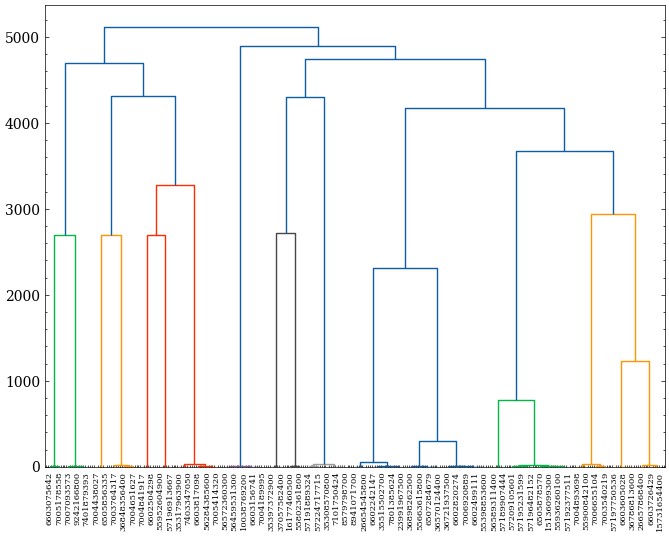

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

Z = hierarchy.linkage(derivative, method)
dn = hierarchy.dendrogram(Z, labels = nodes_list, orientation='top', count_sort='ascending', ax=ax)

plt.show()

## General (us)

In [12]:
h_cut, num_fusion = height_based_cut(Z)

In [13]:
cuttree = hierarchy.cut_tree(Z, height = h_cut)

# Assign each node to its community
node_community_dict = {}
for index, node in enumerate(H.nodes):
    node_community_dict[node] = cuttree[index][0]

# Assign each community its nodes
communities_dict = defaultdict(set)
for node, comm in node_community_dict.items():
    communities_dict[comm].add(node)

In [14]:
Num_communities = len(set(node_community_dict.values()))
print(Num_communities)

16


In [15]:
nodeset_list = []
nodeset_list_names = []
for nodeset in communities_dict.values():
    nodeset_list.append(nodeset)
    nodeset_list_names.append([IDs_dict[ID] for ID in nodeset])
    print([IDs_dict[ID] for ID in nodeset])

    print("###")

['Havlin S.', 'Li D.']
###
['Mendoza C.', 'Bragard J.']
###
['Allaria E.', 'Arecchi F.T.', 'Meucci R.', 'Zhou C.S.', 'Kurths J.']
###
['Mancini H.', 'Maza D.']
###
['Residori S.', 'Bortolozzo U.']
###
['Jia D.', 'Guo H.', 'Wang Z.', 'Shi L.', 'Shen C.', 'Li X.', 'Dai X.', 'Jusup M.', 'Perc M.']
###
['Sevilla-Escoboza R.', 'Papo D.', 'Jaimes-Reátegui R.', 'Zanin M.', 'Sousa P.A.C.', 'Menasalvas E.']
###
['Moskalenko O.I.', 'Makarov V.V.', 'Hramov A.E.', 'Maksimenko V.A.', 'Koronovskii A.A.']
###
['Musatov D.', 'Alfaro-Bittner K.', 'del Genio C.I.', 'Criado R.', 'Raigorodskii A.M.', 'Romance M.']
###
['Frasca M.', 'Moreno Y.', 'Latora V.', 'Gómez-Gardeñes J.']
###
['Qiu T.', 'Liu Z.', 'Bonamassa I.', 'Guan S.', 'Zou Y.']
###
['Barzel B.', 'Zhang X.']
###
['Sendiña-Nadal I.', 'Navas A.', 'Gutiérrez R.', 'Bajo R.', 'Leyva I.', 'Maestú F.', 'Buldú J.', 'del-Pozo F.', 'Almendral J.A.']
###
['Chavez M.', 'Amann A.', 'Hwang D.-U.']
###
['Ramazza P.L.', 'Pampaloni E.', 'Giaquinta A.']
###
['Val

In [16]:
partition_general = nodeset_list

## Modularity (us)

In [17]:
A, G, mapping = reduced_adjacency_matrix(H)

In [18]:
Modularity = calculate_modularities(H, G, Z)

-- 0.0% --
-- 0.746268656716418% --


*Conclusion*: the general method coincides with our modularity maximization in this example

In [19]:
m = max(Modularity)
num_fusion = [i for i, j in enumerate(Modularity) if j == m]
index_max = num_fusion[0]

print(f'Number of communities maximizing the modularity is: {index_max},')
print(f'with modularity: {m}')

Number of communities maximizing the modularity is: 9,
with modularity: 0.6779792723843422


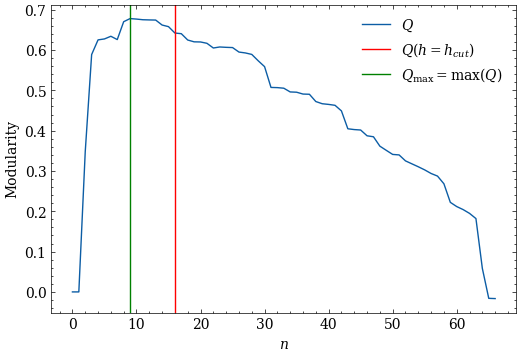

In [20]:
plt.figure(figsize=(6,4))
#plt.title("Modularity score vs Number of communities")
plt.plot(range(len(H.nodes)), Modularity, label='$Q$')
#plt.grid()
plt.axvline(Num_communities, color='r', label='$ Q(h=h_{cut}) $ ')
plt.axvline(index_max, color='g', label='$ Q_{\max}=\max(Q) $ ')

plt.ylabel('Modularity')
plt.xlabel('$ n $')

plt.legend()

plt.savefig('Figures/modularity_collab.svg')

In [21]:
communities_dict = communities(H, derivative, method, n_clusters=index_max)

nodeset_list = []
nodeset_list_names = []
for nodeset in communities_dict.values():
    nodeset_list.append(nodeset)
    nodeset_list_names.append([IDs_dict[ID] for ID in nodeset])
    print([IDs_dict[ID] for ID in nodeset])

    print("###")

['Havlin S.', 'Barzel B.', 'Zhang X.', 'Li D.']
###
['Allaria E.', 'Arecchi F.T.', 'Mendoza C.', 'Bragard J.', 'Mancini H.', 'Meucci R.', 'Zhou C.S.', 'Maza D.', 'Kurths J.']
###
['Ramazza P.L.', 'Giaquinta A.', 'Bortolozzo U.', 'Residori S.', 'Pampaloni E.']
###
['Jia D.', 'Guo H.', 'Wang Z.', 'Shi L.', 'Shen C.', 'Li X.', 'Dai X.', 'Jusup M.', 'Perc M.']
###
['Sevilla-Escoboza R.', 'Papo D.', 'Buldú J.', 'Sendiña-Nadal I.', 'Navas A.', 'del-Pozo F.', 'Gutiérrez R.', 'Bajo R.', 'Leyva I.', 'Jaimes-Reátegui R.', 'Maestú F.', 'Zanin M.', 'Almendral J.A.', 'Sousa P.A.C.', 'Menasalvas E.']
###
['Moskalenko O.I.', 'Makarov V.V.', 'Hramov A.E.', 'Maksimenko V.A.', 'Koronovskii A.A.']
###
['Gómez-Gardeñes J.', 'Latora V.', 'Musatov D.', 'Frasca M.', 'Moreno Y.', 'Alfaro-Bittner K.', 'del Genio C.I.', 'Criado R.', 'Raigorodskii A.M.', 'Romance M.']
###
['Qiu T.', 'Liu Z.', 'Bonamassa I.', 'Guan S.', 'Zou Y.']
###
['Hwang D.-U.', 'Amann A.', 'Pecora L.M.', 'Chavez M.', 'Valladares D.L.']
###


In [22]:
partition_modularity = nodeset_list

### Iterate again over the communities

In [23]:
iterated_partition = []
for comm in nodeset_list:
    
    if len(comm) == 1:
        iterated_partition.append(list(comm))
        print([IDs_dict[list(comm)[0]]])
        
        continue
    
    # Obtain the subhypergraph of the community
    subH = xgi.subhypergraph(H, nodes = comm)
    
    # Compute the derivatives and dendrogram
    sub_derivative = derivative_list(subH)
    subZ = hierarchy.linkage(sub_derivative, method)
        
    # Compute the reduced graph and adjacency matrix
    subA, subG, sub_mapping = reduced_adjacency_matrix(subH)
    
    # Calculate the modularity, and its max
    sub_Modularity = calculate_modularities(subH, subG, subZ, verbose=False)
    
    m = max(sub_Modularity)
    num_fusion = [i for i, j in enumerate(sub_Modularity) if j == m]
    index_max = num_fusion
    
    # Obtain the partition of the subhypergraph
    communities_dict = communities(subH, sub_derivative, method, n_clusters=index_max)
    
    # Print it
    for nodeset in communities_dict.values():
        iterated_partition.append(list(nodeset))
        
        print([IDs_dict[ID] for ID in nodeset])
        print("#######")
        
        
    print("------NEXT------")    
    

['Havlin S.', 'Li D.']
#######
['Barzel B.', 'Zhang X.']
#######
------NEXT------
['Mendoza C.', 'Bragard J.']
#######
['Zhou C.S.', 'Kurths J.']
#######
['Mancini H.', 'Maza D.']
#######
['Meucci R.', 'Allaria E.', 'Arecchi F.T.']
#######
------NEXT------
['Ramazza P.L.', 'Giaquinta A.', 'Bortolozzo U.', 'Residori S.', 'Pampaloni E.']
#######
------NEXT------
['Wang Z.', 'Li X.', 'Dai X.', 'Jusup M.', 'Perc M.']
#######
['Shi L.', 'Guo H.', 'Shen C.', 'Jia D.']
#######
------NEXT------
['Sousa P.A.C.', 'Menasalvas E.']
#######
['Zanin M.', 'Papo D.', 'Buldú J.']
#######
['del-Pozo F.', 'Bajo R.', 'Gutiérrez R.', 'Maestú F.']
#######
['Sevilla-Escoboza R.', 'Jaimes-Reátegui R.']
#######
['Almendral J.A.', 'Leyva I.', 'Sendiña-Nadal I.', 'Navas A.']
#######
------NEXT------
['Moskalenko O.I.', 'Koronovskii A.A.', 'Hramov A.E.']
#######
['Maksimenko V.A.', 'Makarov V.V.']
#######
------NEXT------
['Raigorodskii A.M.']
#######
['Frasca M.', 'Moreno Y.', 'Latora V.', 'Gómez-Gardeñes J.']
#

In [24]:
len(iterated_partition)

24

In [25]:
q = nx.community.modularity(G, iterated_partition)

In [26]:
print(q)

0.5639540632374226


In [27]:
partition_modularity_iterated = iterated_partition

## Modularity (Kumar)

In [ ]:
clusters = IRMM_algorithm(H, tol=1e-3)
Communities_K = []
for comm in clusters:
    Community_K = []
    Community_IDs = []
    for node in comm:
        Community_K.append(mapping[node])
        Community_IDs.append(IDs_dict[mapping[node]])
    Communities_K.append(Community_K)
    
    print(Community_IDs)

q = nx.community.modularity(G,Communities_K)
print(f'The modularity for this partition is: {q}')

In [ ]:
partition_Kumar = Communities_K

## Index between partitions

In [ ]:
partition_list = [partition_general, partition_modularity, partition_modularity_iterated, partition_Kumar]
partition_names = ["general", "modularity", "iterated", "Kumar"]

In [ ]:
Ind_geom = np.zeros((4,4))
Ind_arit = np.zeros((4,4))
for i, part_1 in enumerate(partition_list):
    for j, part_2 in enumerate(partition_list):
        
        Sim_geom, Sim_arit = similarity_partitions(part_1, part_2) 
        
        Ind_geom[i,j] = Sim_geom
        Ind_arit[i,j] = Sim_arit

### Geometric index

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(Ind_geom)

ax.set_xticks(np.arange(len(partition_names)), labels=partition_names, rotation=45)
ax.set_yticks(np.arange(len(partition_names)), labels=partition_names)

for (j, i), label in np.ndenumerate(np.round(Ind_geom,2)):
    ax.text(i, j, label, ha='center', va='center')

### Arithmetic index

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(Ind_arit)

ax.set_xticks(np.arange(len(partition_names)), labels=partition_names, rotation=45)
ax.set_yticks(np.arange(len(partition_names)), labels=partition_names)

for (j, i), label in np.ndenumerate(np.round(Ind_arit,2)):
    ax.text(i, j, label, ha='center', va='center')